In [452]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
import analysis_utils as utils
utils.load_plotting_setting()

from scipy.signal import butter, welch, sosfilt
from scipy.fft import rfft, rfftfreq, irfft

In [453]:
import importlib
importlib.reload(utils)

<module 'analysis_utils' from '/Users/yuhan/work/nanospheres/lorentz_force/analysis_notebook/../analysis_utils.py'>

In [474]:
from scipy.signal.windows import hann
from scipy.special import voigt_profile
from scipy.optimize import curve_fit

def get_sz_measured(dt, zz, n_spectrum, n_chunk, c_mv):
    fs = int(np.ceil(1 / dt))

    size_per_chunk = int(zz.size / n_chunk)
    hann_window = hann(size_per_chunk)

    # Correction factor for Hann windowing
    # See https://dsp.stackexchange.com/questions/93512/effects-of-hanning-window-on-power
    hann_psd_scaling = np.sum(hann_window**2)

    ff, s_zzs, s_ffs = None, [], []
    for i in range(n_spectrum):
        zz_calc = zz[i*size_per_chunk : (i+1)*size_per_chunk]
        zz_windowed = hann_window * zz_calc

        s_zz = np.abs(rfft(zz_windowed))**2 / (fs * hann_psd_scaling)
        s_zzs.append(s_zz)

        ff = rfftfreq(size_per_chunk, dt)

    s_zs = 2 * np.array(s_zzs)
    sz_measured = np.mean(s_zs, axis=0) * c_mv**2
    
    return ff, sz_measured

def voigt(xx, A, x0, sigma, gamma):
    return A * voigt_profile(xx-x0, sigma, gamma)

def fit_sigma_voigt(ff, sz, gamma=None):
    fit_idx_voigt = np.logical_and(ff > 47000, ff < 53000)

    popt, pcov = curve_fit(lambda xx, A, f0, sigma, gamma: voigt(xx, A, f0, sigma, gamma), ff[fit_idx_voigt]*2*np.pi, sz[fit_idx_voigt], 
                           p0=[3e-18, 50500*2*np.pi, 50*2*np.pi, 1*2*np.pi], sigma=sz[fit_idx_voigt])
    
    return popt

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x-mu)**2/(2*sigma**2))

def gaussian_convolved_lineshape(omega, A, omega0, sigma, gamma):
    xx_gauss = np.arange(-400*2*np.pi, 400*2*np.pi, 1)
    gauss_kernel = gauss(xx_gauss, A=1, mu=0, sigma=sigma)
    gauss_kernel /= np.sum(gauss_kernel)

    xx = np.arange(20000*2*np.pi, 350000*2*np.pi, 1)
    actual_lineshape = A / ((xx**2 - omega0**2)**2 + gamma**2 * xx**2)
    
    convolved_lineshape = np.convolve(gauss_kernel, actual_lineshape, 'same')
    return np.interp(omega, xx, convolved_lineshape)

In [455]:
m = 5e-18 # kg  
n_charge = 350
q = n_charge * 1.6e-19 # C
vpp = 350  # V

E0 = vpp / 2 * 100  # V/m
B0 = 100e-4 # Tesla

omega0_x = 220000 * 2 * np.pi
omega0_z = 50000 * 2 * np.pi
omegaE = 276000 * 2 * np.pi

v0 = (q * E0 * omegaE / m) / np.abs((omega0_x**2 - omegaE**2))
F0 = q * v0 * B0

print('Expected diff force amp:', F0 *2 / 1e-18, 'aN')

Expected diff force amp: 0.34716313715722447 aN


In [456]:
fs   = 1250000
f_lp = 10
sos_filt = butter(N=8, Wn=f_lp, btype='lowpass', output='sos', fs=fs)

In [457]:
i = 0
_file_nosubtraction = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_midfreq/20250808_m350e_276khz_350vpp_withb_{i}.hdf5'
_file_wsubtraction = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250813_2e-8mbar_midfreq_fcancel/20250813_m350e_276khz_350vpp_withb_{i}.hdf5'

attrs, tts = utils.get_timestreams(file=_file_nosubtraction, channels=['d', 'g'], attrs=['delta_t'])
dt, zz_0, gg_0 = attrs[0], tts[0], tts[1]

attrs, tts = utils.get_timestreams(file=_file_wsubtraction, channels=['d', 'g'], attrs=['delta_t'])
dt, zz_1, gg_1 = attrs[0], tts[0], tts[1]

In [475]:
c_mv = 1.9653656048711584e-07

ff, sz_measured_0 = get_sz_measured(dt, zz_0, n_spectrum=10, n_chunk=400, c_mv=c_mv)
A, omega0, sigma, gamma_voigt = fit_sigma_voigt(ff, sz_measured_0)
gamma = gamma_voigt * 2
convolved_lineshape = gaussian_convolved_lineshape(ff*2*np.pi, 1, omega0, sigma, gamma)
chi_2_convolved = (1 / (m**2)) * convolved_lineshape
sf_measured_convolved_0 = sz_measured_0 / (chi_2_convolved)

ff, sz_measured_1 = get_sz_measured(dt, zz_1, n_spectrum=10, n_chunk=400, c_mv=c_mv)
A, omega0, sigma, gamma_voigt = fit_sigma_voigt(ff, sz_measured_1)
gamma = gamma_voigt * 2
convolved_lineshape = gaussian_convolved_lineshape(ff*2*np.pi, 1, omega0, sigma, gamma)
chi_2_convolved = (1 / (m**2)) * convolved_lineshape
sf_measured_convolved_1 = sz_measured_1 / (chi_2_convolved)

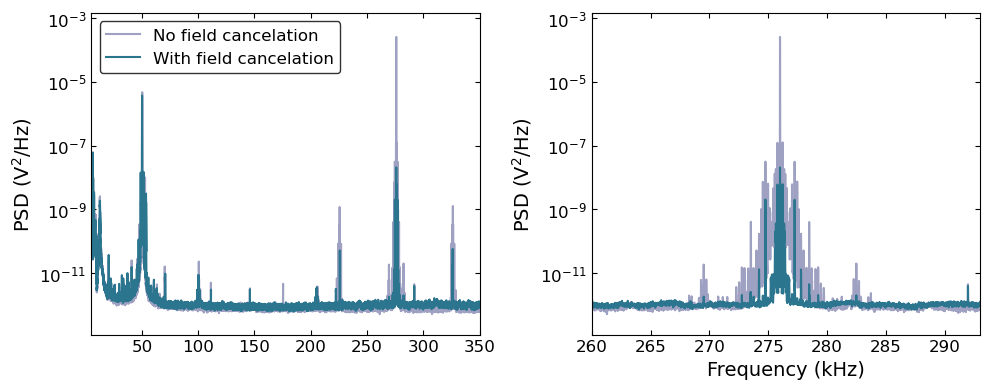

In [ ]:
ff0, pp0 = welch(zz_0, fs=fs, nperseg=2**17)
ff1, pp1 = welch(zz_1, fs=fs, nperseg=2**17)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax in axes:
    ax.plot(ff0/1000 ,pp0, alpha=0.5, label='No field cancelation')
    ax.plot(ff1/1000 ,pp1, label='With field cancelation')

    ax.set_yscale('log')
axes[1].set_xlabel('Frequency (kHz)')
axes[0].set_ylabel('PSD (V$^2$/Hz)')
axes[1].set_ylabel('PSD (V$^2$/Hz)')

axes[0].legend(edgecolor='k')

axes[0].set_xlim(5, 350)
axes[1].set_xlim(260, 293)

fig.tight_layout()

Text(0, 0.5, 'Force ASD (N/$\\sqrt{\\mathrm{Hz}}$)')

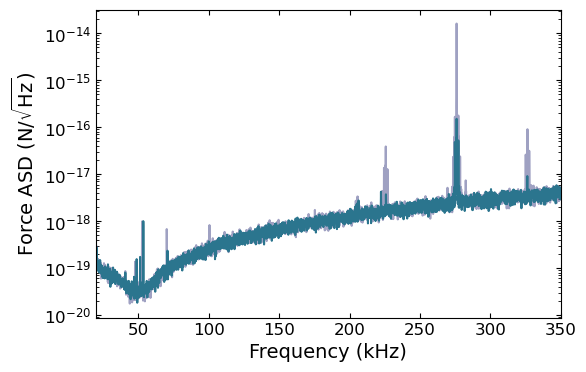

In [476]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.plot(ff/1000, np.sqrt(sf_measured_convolved_0), alpha=0.5)
ax.plot(ff/1000, np.sqrt(sf_measured_convolved_1))

ax.set_xlim(20, 350)
ax.set_yscale('log')

ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel(r'Force ASD (N/$\sqrt{\mathrm{Hz}}$)')

In [5]:
gg_normalized_0 = utils.normalized_drive(gg_0)
gg_normalized_1 = utils.normalized_drive(gg_1)

ee_0, bb_0 = utils.get_eb_comp(dt, zz_0, gg_normalized_0, sos_filt)
ee_1, bb_1 = utils.get_eb_comp(dt, zz_1, gg_normalized_1, sos_filt)

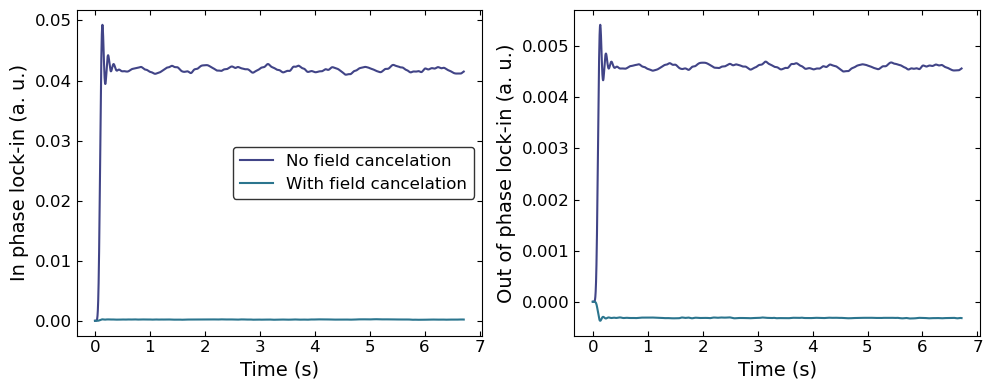

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

tt = np.arange(0, dt*zz_0.size, dt)
axes[0].plot(tt, ee_0, label='No field cancelation')
axes[0].plot(tt, ee_1, label='With field cancelation')

axes[1].plot(tt, bb_0)
axes[1].plot(tt, bb_1)

axes[0].legend(edgecolor='k', loc='center right')
axes[0].set_ylabel('In phase lock-in (a. u.)')
axes[1].set_ylabel('Out of phase lock-in (a. u.)')
for ax in axes:
    ax.set_xlabel('Time (s)')

fig.tight_layout()

In [90]:
ff = rfftfreq(n=zz_0.size, d=dt)

ggf_0 = rfft(gg_normalized_0)
zzf_0 = rfft(zz_0)

ggf_1 = rfft(gg_normalized_1)
zzf_1 = rfft(zz_1)

In [108]:
f_drive = ff[np.argmax(ggf_0)]  # drive frequency (Hz)

half_bandwidth = 250
idx_signal = np.logical_and(ff > f_drive-half_bandwidth, ff < f_drive+half_bandwidth)

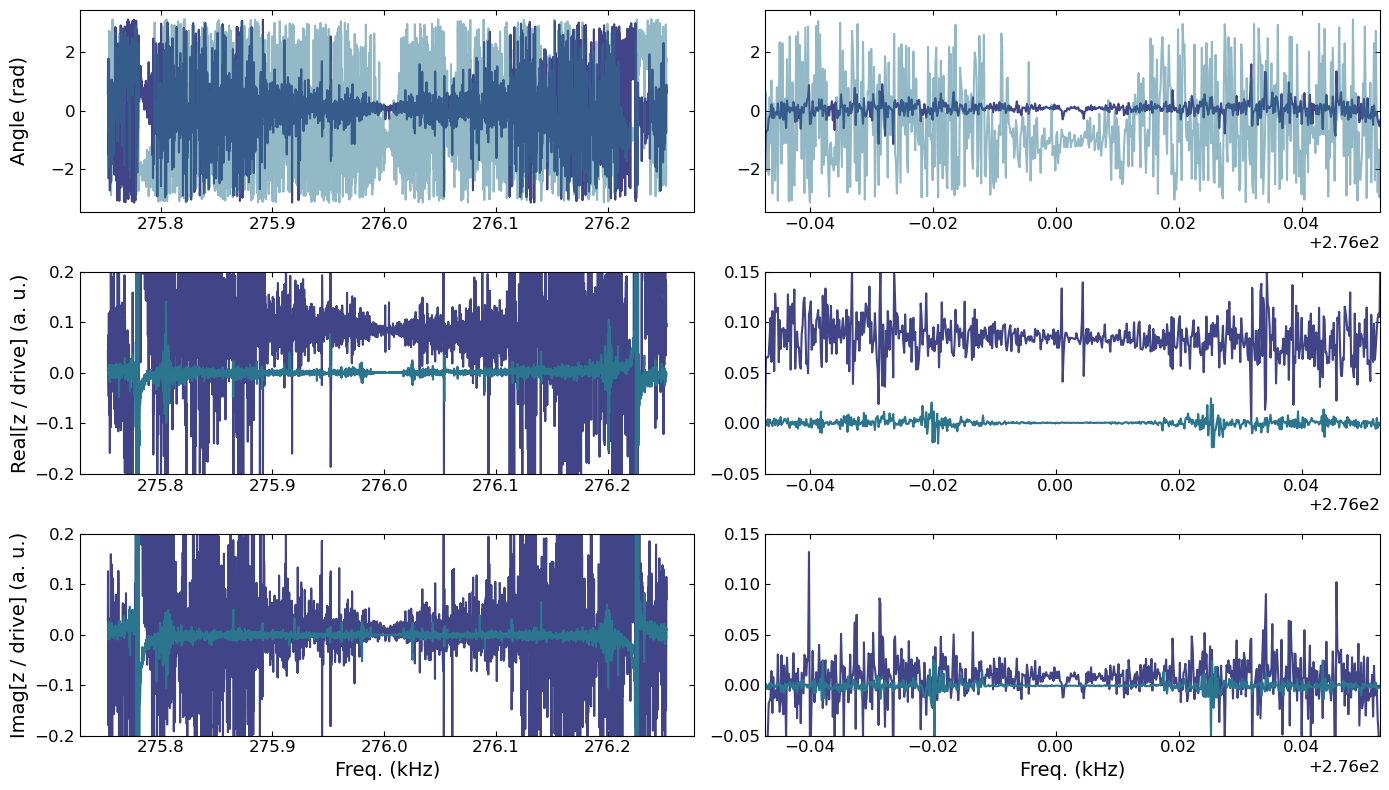

In [134]:
fig, axes = plt.subplots(3, 2, figsize=(14, 8))

for ax in axes[0]:
    ax.plot(ff[idx_signal]/1000, np.angle(zzf_0[idx_signal] / ggf_0[idx_signal]))
    ax.plot(ff[idx_signal]/1000, np.angle(zzf_1[idx_signal] / ggf_1[idx_signal]), alpha=0.5)

for ax in axes[1]:
    ax.plot(ff[idx_signal]/1000, np.real(zzf_0[idx_signal] / ggf_0[idx_signal]))
    ax.plot(ff[idx_signal]/1000, np.real(zzf_1[idx_signal] / ggf_1[idx_signal]))

for ax in axes[2]:
    ax.plot(ff[idx_signal]/1000, np.imag(zzf_0[idx_signal] / ggf_0[idx_signal]))
    ax.plot(ff[idx_signal]/1000, np.imag(zzf_1[idx_signal] / ggf_1[idx_signal]))

axes[1, 0].set_ylim(-2e-1, 2e-1)
axes[2, 0].set_ylim(-2e-1, 2e-1)

axes[1, 1].set_ylim(-0.05, 0.15)
axes[2, 1].set_ylim(-0.05, 0.15)

for ax in axes.T[1]:
    ax.set_xlim((f_drive-50)/1000, (f_drive+50)/1000)

for ax in axes[2]:
    ax.set_xlabel('Freq. (kHz)')
axes[0,0].set_ylabel('Angle (rad)')
axes[1,0].set_ylabel('Real[z / drive] (a. u.)')
axes[2,0].set_ylabel('Imag[z / drive] (a. u.)')

fig.align_labels()
fig.tight_layout()

### Calibrate signal to force units

In [136]:
_files = [r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_electric_calibration/20250808_m350e_276khz_2_5vpp_nob_0.hdf5',
          r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_electric_calibration/20250808_m350e_276khz_5vpp_nob_0.hdf5',
          r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_electric_calibration/20250808_m350e_276khz_7_5vpp_nob_0.hdf5']

attrs, tts = utils.get_timestreams(file=_files[0], channels=['d', 'g'], attrs=['delta_t'])
dt, zzc_0, ggc_0 = attrs[0], tts[0], tts[1]

attrs, tts = utils.get_timestreams(file=_files[1], channels=['d', 'g'], attrs=['delta_t'])
dt, zzc_1, ggc_1 = attrs[0], tts[0], tts[1]

attrs, tts = utils.get_timestreams(file=_files[2], channels=['d', 'g'], attrs=['delta_t'])
dt, zzc_2, ggc_2 = attrs[0], tts[0], tts[1]

In [ ]:
gg_normalized_0 = utils.normalized_drive(ggc_0)
gg_normalized_1 = utils.normalized_drive(ggc_1)
gg_normalized_2 = utils.normalized_drive(ggc_2)

ff = rfftfreq(n=zz_0.size, d=dt)

ggf_0 = rfft(gg_normalized_0)
zzf_0 = rfft(zzc_0)

ggf_1 = rfft(gg_normalized_1)
zzf_1 = rfft(zzc_1)

ggf_2 = rfft(gg_normalized_2)
zzf_2 = rfft(zzc_2)

In [ ]:
drive_idx = np.argmax(ggf_0)

drive_amps = np.array([2.5, 5, 7.5])
drive_force_amps = (drive_amps / 2) * 106 * 350 * 1.6e-19 # N

sig_in_amps = [np.real(zzf_0[drive_idx] / ggf_0[drive_idx]), np.real(zzf_1[drive_idx] / ggf_1[drive_idx]), np.real(zzf_2[drive_idx] / ggf_2[drive_idx])]
sig_out_amps = [np.imag(zzf_0[drive_idx] / ggf_0[drive_idx]), np.imag(zzf_1[drive_idx] / ggf_1[drive_idx]), np.imag(zzf_2[drive_idx] / ggf_2[drive_idx])]

fit = np.polyfit(drive_force_amps, sig_in_amps, deg=1)
signal_2_newton = 1 / fit[0]

In [252]:
print(f'In-phase signal to Newton conversion factor: {signal_2_newton}')

In-phase signal to Newton conversion factor: -1.657316817379686e-11


(-0.0015, 0.0)

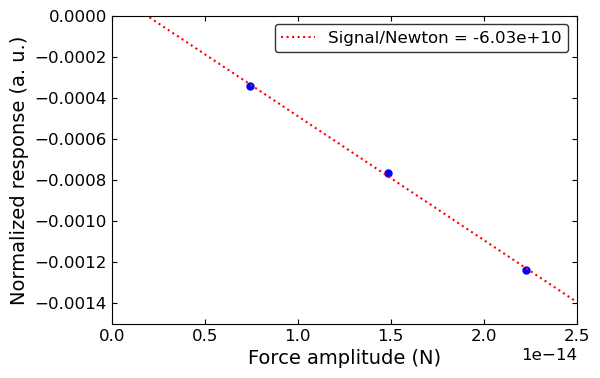

In [193]:
plt.figure(figsize=(6, 4))

plt.plot(drive_force_amps, sig_in_amps, 'b.', markersize=10)
xx = np.linspace(0, 2.5e-14, 200)
plt.plot(xx, xx*fit[0] + fit[1], 'r:', label=f'Signal/Newton = {fit[0]:.2e}')

plt.xlabel('Force amplitude (N)')
plt.ylabel('Normalized response (a. u.)')

plt.legend(edgecolor='k')
plt.xlim(0, 2.5e-14)
plt.ylim(-0.0015, 0)
# plt.plot(drive_amps, sig_out_amps)

### Process the data

In [ ]:
nstart = [1000, 1500, 2000]
nfile = 500
_sig_out_amps_diff = np.empty(nfile)

for j in nstart:
    for i in range(j, j+nfile):
        if i % 5 == 0:
            print(i)
        
        _file_0 = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250813_2e-8mbar_midfreq_fcancel/20250813_m350e_276khz_350vpp_withb_{i}.hdf5'
        _file_1 = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250813_2e-8mbar_midfreq_fcancel/20250813_m350e_276khz_350vpp_withb_flipped_{i}.hdf5'

        attrs, tts = utils.get_timestreams(file=_file_0, channels=['d', 'g'], attrs=['delta_t'])
        dt, zz_0, gg_0 = attrs[0], tts[0], tts[1]

        attrs, tts = utils.get_timestreams(file=_file_1, channels=['d', 'g'], attrs=['delta_t'])
        dt, zz_1, gg_1 = attrs[0], tts[0], tts[1]

        # _file_n = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250813_2e-8mbar_midfreq_fcancel/20250813_m350e_276khz_350vpp_nob_{i}.hdf5'
        # attrs, tts = utils.get_timestreams(file=_file_n, channels=['d', 'g'], attrs=['delta_t'])
        # dt, zz_n, gg_n = attrs[0], tts[0], tts[1]

        gg_normalized_0 = utils.normalized_drive(gg_0)
        gg_normalized_1 = utils.normalized_drive(gg_1)

        ggf_0 = rfft(gg_normalized_0)
        zzf_0 = rfft(zz_0)

        ggf_1 = rfft(gg_normalized_1)
        zzf_1 = rfft(zz_1)

        drive_idx = np.argmax(ggf_0)
        _sig_out_amps_diff[i-j] = np.imag(zzf_0[drive_idx] / ggf_0[drive_idx]) - np.imag(zzf_1[drive_idx] / ggf_1[drive_idx])

    np.savez(f'force_diff_20250813_2e-8mbar_midfreq_fcancel_{j}_{j+499}.npz', force_diff=_sig_out_amps_diff * signal_2_newton)

1000
1005
1010
1015
1020
1025
1030
1035
1040
1045
1050
1055
1060
1065
1070
1075
1080
1085
1090
1095
1100
1105
1110
1115
1120
1125
1130
1135
1140
1145
1150
1155
1160
1165
1170
1175
1180
1185
1190
1195
1200
1205
1210
1215
1220
1225
1230
1235
1240
1245
1250
1255
1260
1265
1270
1275
1280
1285
1290
1295
1300
1305
1310
1315
1320
1325
1330
1335
1340
1345
1350
1355
1360
1365
1370
1375
1380
1385
1390
1395
1400
1405
1410
1415
1420
1425
1430
1435
1440
1445
1450
1455
1460
1465
1470
1475
1480
1485
1490
1495
1500
1505
1510
1515
1520
1525
1530
1535
1540
1545
1550
1555
1560
1565
1570
1575
1580
1585
1590
1595
1600
1605
1610
1615
1620
1625
1630
1635
1640
1645
1650
1655
1660
1665
1670
1675
1680
1685
1690
1695
1700
1705
1710
1715
1720
1725
1730
1735
1740
1745
1750
1755
1760
1765
1770
1775
1780
1785
1790
1795
1800
1805
1810
1815
1820
1825
1830
1835
1840
1845
1850
1855
1860
1865
1870
1875
1880
1885
1890
1895
1900
1905
1910
1915
1920
1925
1930
1935
1940
1945
1950
1955
1960
1965
1970
1975
1980
1985
1990
1995


### Perform a profile likelihood fit

In [436]:
be = np.linspace(-1e-14, 1e-14, 500)
bc = 0.5 * (be[1:] + be[:-1])
hist_diff_all = np.zeros(bc.size)

force_diff_all = []
for j in [0, 500, 1000, 1500, 2000]:
    _force_diff = np.load(f'force_diff_20250813_2e-8mbar_midfreq_fcancel_{j}_{j+499}.npz')['force_diff']
    force_diff_all.append(_force_diff)

    hh_diff, _ = np.histogram(_force_diff, bins=be)
    hist_diff_all += hh_diff

force_diff_all = np.concatenate(force_diff_all)

Text(0.5, 0, 'File index')

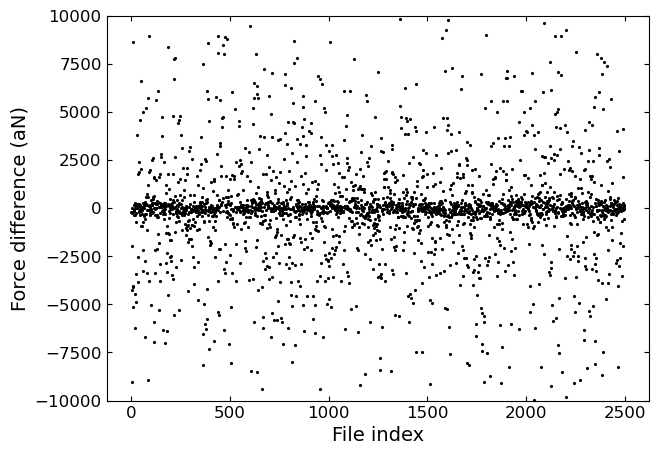

In [442]:
plt.plot(force_diff_all/1e-18, 'k.', markersize=2.5)
plt.ylim(-10000, 10000)

plt.ylabel('Force difference (aN)')
plt.xlabel('File index')

In [426]:
from scipy.optimize import minimize

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

def nll_gaus(A, sigma, mu, bc, hist):
    mui = gauss(bc, A, mu, sigma)
    mui[ mui < 1e-30 ] = 1e-30
    
    ni = hist
    return np.sum(np.nan_to_num(mui - ni * np.log(mui)))

def minimize_nll(bc, hist, bounds=None):
    args = (bc, hist)

    res = minimize(fun=lambda x: nll_gaus(*x, *args), x0=[np.max(hist), 100, 0],
            method='Nelder-Mead',
            bounds=bounds,
            options={'disp' : False,
                    'maxiter': 50000,
                    'maxfev': 50000,
                    'adaptive': True,
                    'fatol': 0.001,
                    }
            )
    if res.success:
        return res.fun, res.x
    else:
        return np.nan, np.full(3, np.nan)
    
def minimize_nll_fixedmu(mu, bc, hist, bounds=None):
    args = (mu, bc, hist)

    res = minimize(fun=lambda x: nll_gaus(*x, *args), x0=[np.max(hist), 200],
            method='Nelder-Mead',
            bounds=bounds,
            options={'disp' : False,
                    'maxiter': 50000,
                    'maxfev': 50000,
                    'adaptive': True,
                    'fatol': 0.001,
                    }
            )
    if res.success:
        return res.fun, res.x
    else:
        return np.nan, np.full(3, np.nan)

In [427]:
bc_aN = bc / 1e-18
idx_fit = np.logical_and(bc_aN > -400, bc_aN < 400)

mus = np.linspace(-20, 30, 100)
nlls = np.empty_like(mus)

for i, mu in enumerate(mus):
    _nll, _params = minimize_nll_fixedmu(mu, bc_aN[idx_fit], hist_diff_all[idx_fit])
    nlls[i] = _nll

nll, params = minimize_nll(bc_aN[idx_fit], hist_diff_all[idx_fit])

idx_search_pos = mus > mus[np.argmin(nlls)]
sigma_mu_pos = np.interp(1, 2 * (nlls-np.min(nlls))[idx_search_pos], mus[idx_search_pos])

idx_search_neg = mus < mus[np.argmin(nlls)]
sigma_mu_neg = np.interp(1, np.flip(2 * (nlls-np.min(nlls))[idx_search_neg]), np.flip(mus[idx_search_neg]))


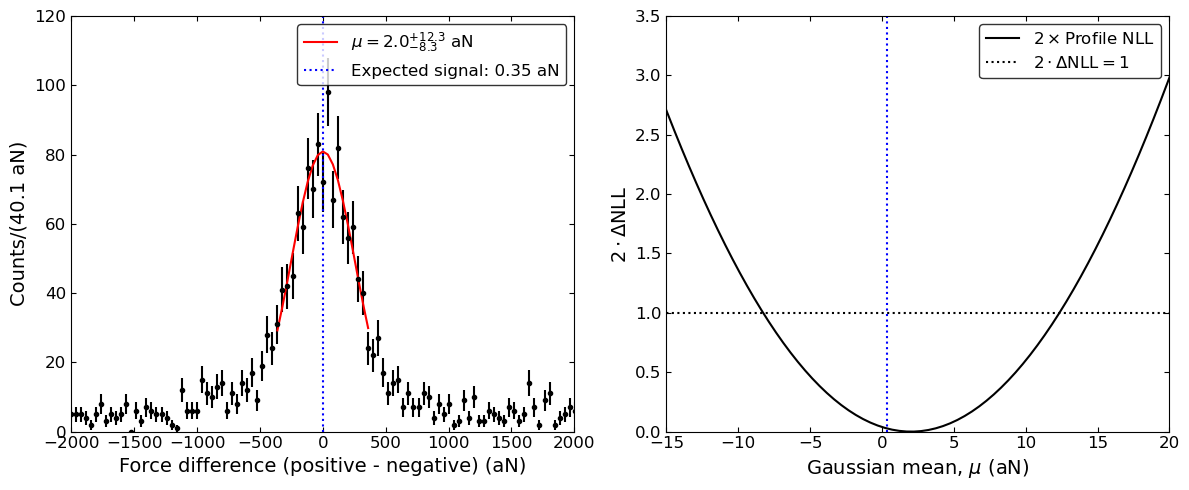

In [429]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].errorbar(bc/1e-18, hist_diff_all, yerr=np.sqrt(hist_diff_all), fmt='.', color='k')
axes[0].plot(bc_aN[idx_fit], gauss(bc_aN[idx_fit], params[0], params[2], params[1]), color='r', label=fr'$\mu = {params[2]:.1f}^{{+{sigma_mu_pos:.1f}}}_{{-{np.abs(sigma_mu_neg):.1f}}}$ aN')
axes[0].vlines(F0*2/1e-18, 0, 150, color='b',linestyle=':', label=rf'Expected signal: {F0*2/1e-18:.2f} aN')

axes[1].plot(mus, 2 * (nlls - np.min(nlls)), 'k', label=r'$2 \times$Profile NLL')
axes[1].hlines(1, -30, 30, color='k',linestyle=':', label=r'$2 \cdot \Delta \mathrm{NLL} = 1$')
axes[1].vlines(F0*2/1e-18, 0, 5, color='b',linestyle=':')

axes[1].legend(edgecolor='k', fontsize=12)
axes[0].legend(edgecolor='k', fontsize=12)
axes[0].set_xlabel('Force difference (positive - negative) (aN)')
axes[0].set_ylabel(rf'Counts/({bc_aN[1]-bc_aN[0]:.1f} aN)')

axes[1].set_xlabel(r'Gaussian mean, $\mu$ (aN)')
axes[1].set_ylabel(r'$2 \cdot \Delta \mathrm{NLL}$')

axes[0].set_xlim(-2000, 2000)
axes[0].set_ylim(0, 120)
axes[1].set_xlim(-15, 20)
axes[1].set_ylim(0, 3.5)

fig.tight_layout()

### Now try the lock-in

#### Calibrate the lock-in signal using the calibration tone

In [ ]:
_files = [r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_electric_calibration/20250808_m350e_276khz_2_5vpp_nob_0.hdf5',
          r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_electric_calibration/20250808_m350e_276khz_5vpp_nob_0.hdf5',
          r'/Volumes/LaCie/lorentz_force/sphere_20250708/20250808_2e-8mbar_electric_calibration/20250808_m350e_276khz_7_5vpp_nob_0.hdf5']

attrs, tts = utils.get_timestreams(file=_files[0], channels=['d', 'g'], attrs=['delta_t'])
dt, zz_0, gg_0 = attrs[0], tts[0], tts[1]

attrs, tts = utils.get_timestreams(file=_files[1], channels=['d', 'g'], attrs=['delta_t'])
dt, zz_1, gg_1 = attrs[0], tts[0], tts[1]

attrs, tts = utils.get_timestreams(file=_files[2], channels=['d', 'g'], attrs=['delta_t'])
dt, zz_2, gg_2 = attrs[0], tts[0], tts[1]

In [ ]:
gg_normalized_0 = utils.normalized_drive(gg_0)
gg_normalized_1 = utils.normalized_drive(gg_1)
gg_normalized_2 = utils.normalized_drive(gg_2)

ee_0, bb_0 = utils.get_eb_comp(dt, zz_0, gg_normalized_0)
ee_1, bb_1 = utils.get_eb_comp(dt, zz_1, gg_normalized_1)
ee_2, bb_2 = utils.get_eb_comp(dt, zz_2, gg_normalized_2)

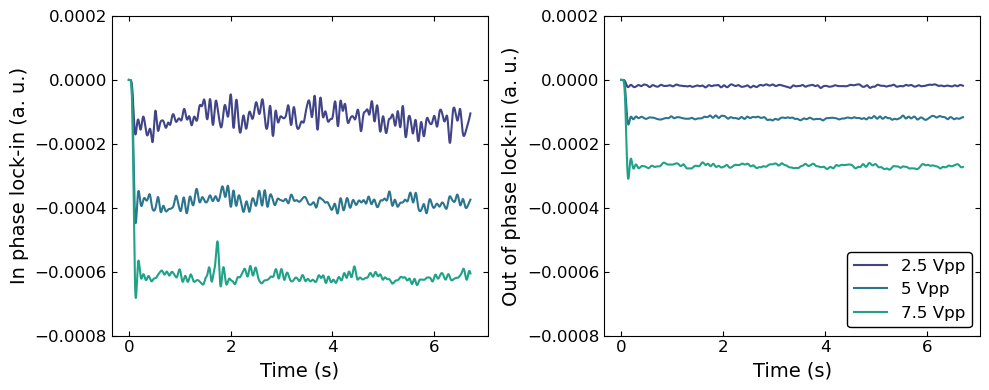

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

tt = np.arange(0, dt*zz_0.size, dt)

axes[0].plot(tt, ee_0)
axes[0].plot(tt, ee_1)
axes[0].plot(tt, ee_2)

axes[1].plot(tt, bb_0, label='2.5 Vpp')
axes[1].plot(tt, bb_1, label='5 Vpp')
axes[1].plot(tt, bb_2, label='7.5 Vpp')

for ax in axes:
    ax.set_xlabel('Time (s)')
    ax.set_ylim(-0.0008, 0.0002)

axes[0].set_ylabel('In phase lock-in (a. u.)')
axes[1].set_ylabel('Out of phase lock-in (a. u.)')

axes[1].legend(edgecolor='k', framealpha=1, loc='lower right')
fig.tight_layout()

In [ ]:
vpp   = np.array([2.5, 5, 7.5])

v_amp = vpp / 2
efield = 106            # V/m per volt
charge = 350 * 1.6e-19  # Coulomb
f_amp = v_amp * efield * charge # N

# lockin_2_newtons = np.empty(3)
# for i, ee in enumerate([ee_0, ee_1, ee_2]):
#     lockin_2_newtons[i] = f_amp[i] / np.mean(ee[1000000:])
# print(f'Lock-in to Newton factors: {lockin_2_newtons}')

# lockin_2_newton = lockin_2_newtons[2]

ees_mean = [np.mean(ee[1000000:]) for ee in [ee_0, ee_1, ee_2]]
fit = np.polyfit(f_amp, ees_mean, deg=1)
lockin_2_newton = 1 / fit[0]

print(f'In-phase lock-in signal to Newton conversion factor: {lockin_2_newton}')

In-phase lock-in signal to Newton conversion factor: -2.964828606518386e-11


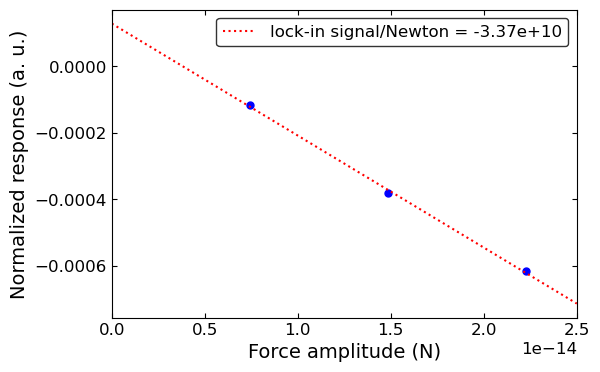

In [ ]:
plt.figure(figsize=(6, 4))

xx = np.linspace(0, 2.5e-14, 200)
plt.plot(f_amp, ees_mean, 'b.', markersize=10)
plt.plot(xx, xx*fit[0] + fit[1], 'r:', label=f'lock-in signal/Newton = {fit[0]:.2e}')
plt.xlim(0, 2.5e-14)

plt.xlabel('Force amplitude (N)')
plt.ylabel('Normalized response (a. u.)')
plt.legend(edgecolor='k')

In [327]:
lockin_2_newton = -2.964828606518386e-11

fs   = 1250000
f_lp = 10

sos_filt = butter(N=8, Wn=f_lp, btype='lowpass', output='sos', fs=fs)

In [335]:
nstart = [0, 500, 1000, 1500, 2000]
nfile = 500

for j in nstart:
    _sig_out_amps_diff_lockin = np.empty(nfile)

    for i in range(j, j+nfile):
        if i % 50 == 0:
            print(i)
        
        _file_0 = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250813_2e-8mbar_midfreq_fcancel/20250813_m350e_276khz_350vpp_withb_{i}.hdf5'
        _file_1 = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250813_2e-8mbar_midfreq_fcancel/20250813_m350e_276khz_350vpp_withb_flipped_{i}.hdf5'

        attrs, tts = utils.get_timestreams(file=_file_0, channels=['d', 'g'], attrs=['delta_t'])
        dt, zz_0, gg_0 = attrs[0], tts[0], tts[1]

        attrs, tts = utils.get_timestreams(file=_file_1, channels=['d', 'g'], attrs=['delta_t'])
        dt, zz_1, gg_1 = attrs[0], tts[0], tts[1]

        gg_normalized_0 = utils.normalized_drive(gg_0)
        gg_normalized_1 = utils.normalized_drive(gg_1)

        ee_0, bb_0 = utils.get_eb_comp(dt, zz_0, gg_normalized_0, sos_filt)
        ee_1, bb_1 = utils.get_eb_comp(dt, zz_1, gg_normalized_1, sos_filt)

        _diff = utils.get_diff_newton_nocorr(bb_0, bb_1, lockin_2_newton)
        _sig_out_amps_diff_lockin[i-j] = np.mean(_diff)

    np.savez(f'force_diff_lockin_20250813_2e-8mbar_midfreq_fcancel_{j}_{j+499}.npz', force_diff=_sig_out_amps_diff_lockin)


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450


In [443]:
be = np.linspace(-1e-15, 1e-15, 200)
bc = 0.5 * (be[1:] + be[:-1])
hist_diff_all_lockin = np.zeros(bc.size)

force_diff_lockin = []
for j in [0, 500, 1000, 1500, 2000]:
    _force_diff = np.load(f'force_diff_lockin_20250813_2e-8mbar_midfreq_fcancel_{j}_{j+499}.npz')['force_diff']
    force_diff_lockin.append(_force_diff)

    hh_diff, _ = np.histogram(_force_diff, bins=be)
    hist_diff_all_lockin += hh_diff

force_diff_lockin = np.concatenate(force_diff_lockin)

Text(0.5, 0, 'File index')

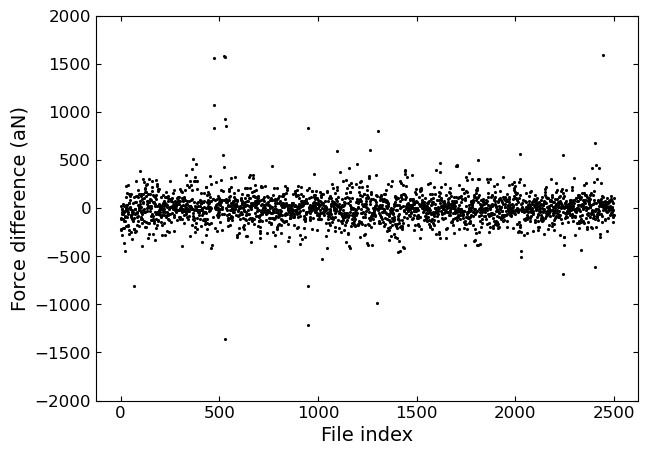

In [445]:
plt.plot(force_diff_lockin/1e-18, 'k.', markersize=2.5)
plt.ylim(-2000, 2000)

plt.ylabel('Force difference (aN)')
plt.xlabel('File index')

In [433]:
bc_aN = bc / 1e-18
idx_fit = np.logical_and(bc_aN > -120, bc_aN < 120)

mus = np.linspace(-10, 10, 100)
nlls = np.empty_like(mus)

for i, mu in enumerate(mus):
    _nll, _params = minimize_nll_fixedmu(mu, bc_aN[idx_fit], hist_diff_all_lockin[idx_fit])
    nlls[i] = _nll

nll, params = minimize_nll(bc_aN[idx_fit], hist_diff_all_lockin[idx_fit])

idx_search_pos = mus > mus[np.argmin(nlls)]
sigma_mu_pos = np.interp(1, 2 * (nlls-np.min(nlls))[idx_search_pos], mus[idx_search_pos])

idx_search_neg = mus < mus[np.argmin(nlls)]
sigma_mu_neg = np.interp(1, np.flip(2 * (nlls-np.min(nlls))[idx_search_neg]), np.flip(mus[idx_search_neg]))


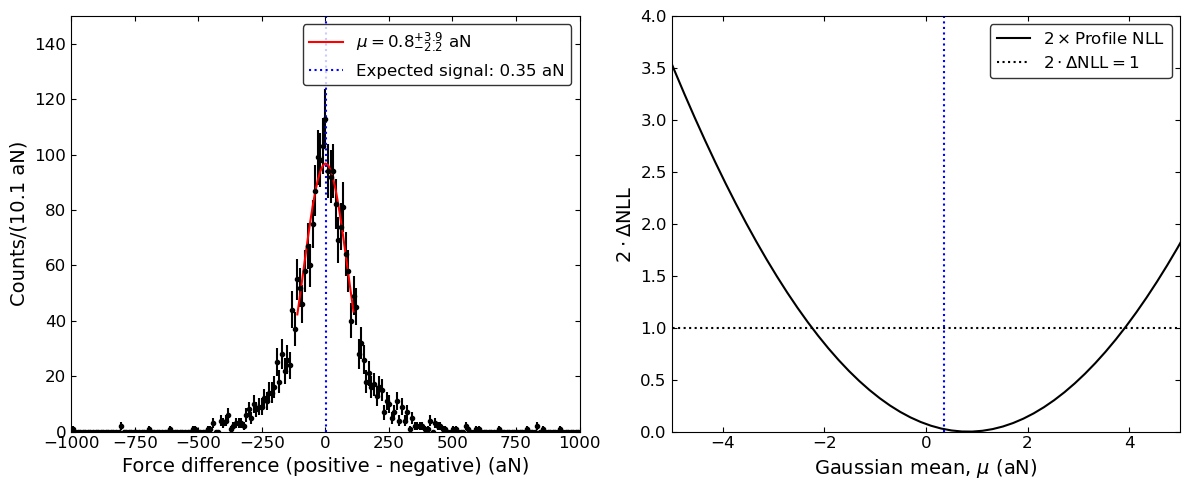

In [434]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].errorbar(bc/1e-18, hist_diff_all_lockin, np.sqrt(hist_diff_all_lockin), fmt='.', color='k')
axes[0].plot(bc_aN[idx_fit], gauss(bc_aN[idx_fit], params[0], params[2], params[1]), color='r', label=fr'$\mu = {params[2]:.1f}^{{+{sigma_mu_pos:.1f}}}_{{-{np.abs(sigma_mu_neg):.1f}}}$ aN')
axes[0].vlines(F0*2/1e-18, 0, 150, color='b',linestyle=':', label=f'Expected signal: {F0*2/1e-18:.2f} aN')

axes[1].plot(mus, 2 * (nlls - np.min(nlls)), 'k', label=r'$2 \times$Profile NLL')
axes[1].hlines(1, -30, 30, color='k',linestyle=':', label=r'$2 \cdot \Delta \mathrm{NLL} = 1$')
axes[1].vlines(F0*2/1e-18, 0, 5, color='b',linestyle=':')

axes[0].legend(edgecolor='k')
axes[1].legend(edgecolor='k')

axes[0].set_xlabel('Force difference (positive - negative) (aN)')
axes[0].set_ylabel(rf'Counts/({bc_aN[1]-bc_aN[0]:.1f} aN)')

axes[1].set_xlabel(r'Gaussian mean, $\mu$ (aN)')
axes[1].set_ylabel(r'$2 \cdot \Delta \mathrm{NLL}$')

axes[0].set_xlim(-1000, 1000)
axes[0].set_ylim(0, 150)

axes[1].set_xlim(-5, 5)
axes[1].set_ylim(0, 4)

fig.tight_layout()

In [19]:
_file = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250813_2e-8mbar_midfreq_fcancel/20250813_m350e_276khz_350vpp_withb_{i}.hdf5'

attrs, tts = utils.get_timestreams(file=_file, channels=['d', 'g'], attrs=['delta_t'])
dt, zz, gg = attrs[0], tts[0], tts[1]

In [ ]:


gg_normalized = utils.normalized_drive(gg)

sos_bp = butter(N=8, Wn=[260000, 290000], btype='bandpass', output='sos', fs=fs)
zz_bp  = sosfilt(sos_bp, zz)
gg_bp  = sosfilt(sos_bp, gg_normalized)

ff, ppz = welch(zz, fs, nperseg=2**18)
ff, ppz_bp = welch(zz_bp, fs, nperseg=2**18)
ff, ppg = welch(gg_bp, fs, nperseg=2**18)

Text(0, 0.5, 'PSD (V$^2$/Hz)')

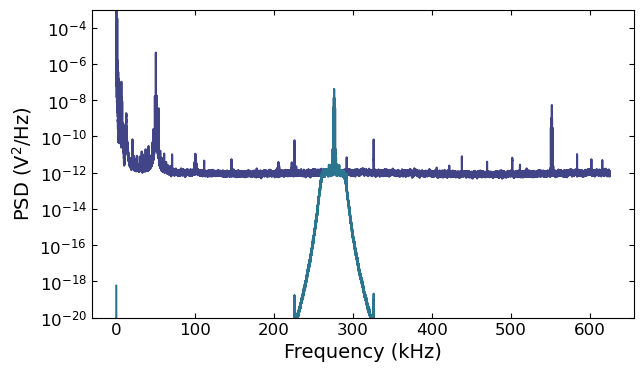

In [84]:
plt.figure(figsize=(7, 4))

plt.plot(ff/1000, ppz)
plt.plot(ff/1000, ppz_bp)
# plt.plot(ff/1000, ppg, 'r', alpha=0.4)

plt.yscale('log')
plt.ylim(1e-20, 1e-3)
# plt.xlim(270, 280)

plt.xlabel('Frequency (kHz)')
plt.ylabel('PSD (V$^2$/Hz)')

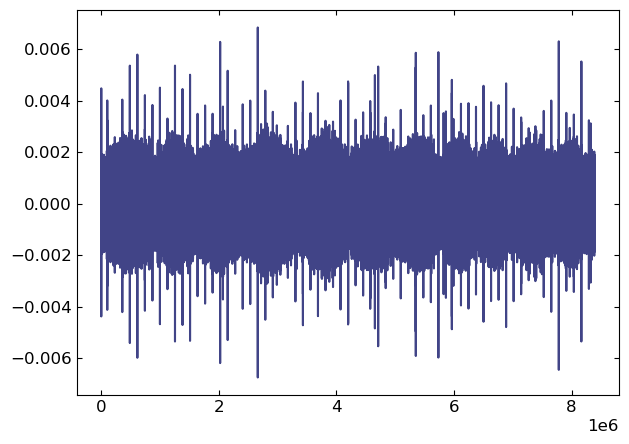

In [88]:
plt.plot(zz_bp)
# plt.xlim(0, 1000)

(0.0, 500.0)

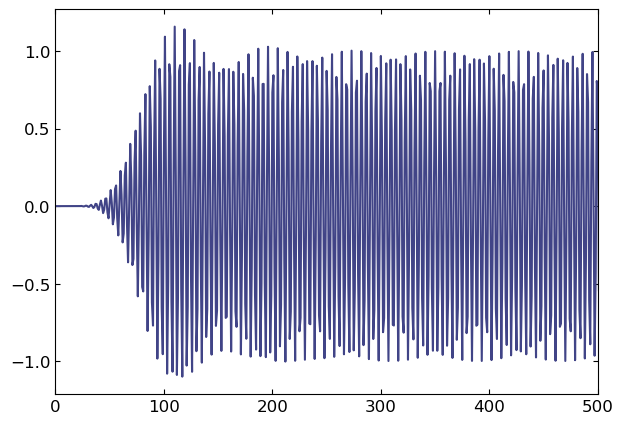

In [76]:
plt.plot(gg_bp)
plt.xlim(0, 500)

In [66]:
zz_bp_f = rfft(zz_bp[100000:])
gg_bp_f = rfft(gg_bp[100000:])

filtered = irfft(np.conjugate(gg_bp_f) * zz_bp_f)

In [68]:
np.sum(np.conjugate(gg_bp_f) * zz_bp_f)

(7135928539.633636-11090284706.17599j)

(0.0, 100.0)

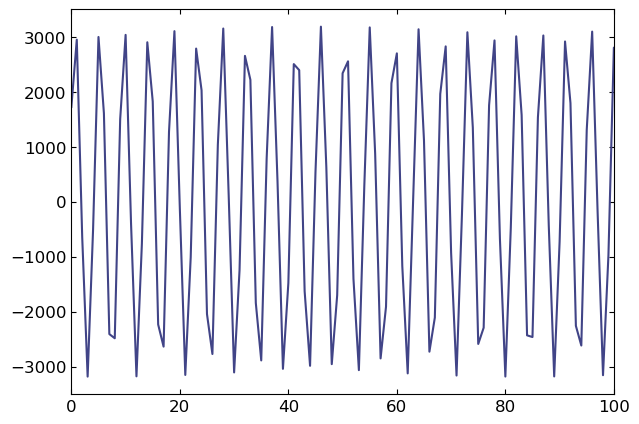

In [135]:
plt.plot(filtered)
plt.xlim(0, 100)

(-10.0, 10.0)

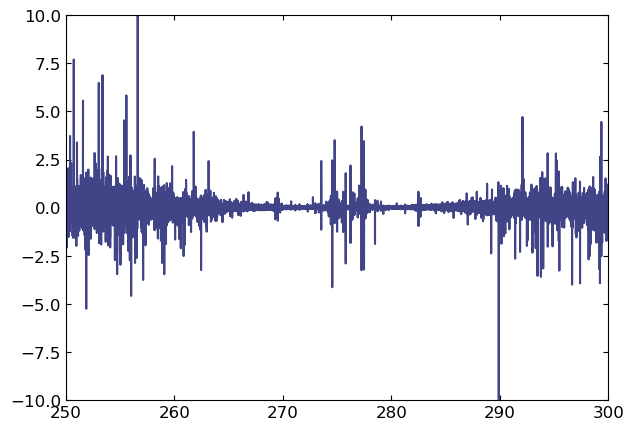

In [15]:
plt.plot(ff/1000, np.real(zzf_0 / ggf_0))

plt.xlim(250, 300)
plt.ylim(-10, 10)

In [ ]:
nfile = 25
bb_diff    = np.empty(nfile)
bb_diff_0n = np.empty(nfile)
bb_diff_1n = np.empty(nfile)

be = np.linspace(-5e-15, 5e-15, 250)
bc = 0.5 * (be[1:] + be[:-1])
hist_diff = np.zeros(bc.size, dtype=np.int64)
hist_diff_nob_0 = np.zeros(bc.size, dtype=np.int64)
hist_diff_nob_1 = np.zeros(bc.size, dtype=np.int64)

for i in range(nfile):
    if i % 5 == 0:
        print(i)
    
    _file_0 = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250813_2e-8mbar_midfreq_fcancel/20250813_m350e_276khz_350vpp_withb_{i}.hdf5'
    _file_1 = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250813_2e-8mbar_midfreq_fcancel/20250813_m350e_276khz_350vpp_withb_flipped_{i}.hdf5'
    _file_n = rf'/Volumes/LaCie/lorentz_force/sphere_20250708/20250813_2e-8mbar_midfreq_fcancel/20250813_m350e_276khz_350vpp_nob_{i}.hdf5'

    attrs, tts = utils.get_timestreams(file=_file_0, channels=['d', 'g'], attrs=['delta_t'])
    dt, zz_0, gg_0 = attrs[0], tts[0], tts[1]

    attrs, tts = utils.get_timestreams(file=_file_1, channels=['d', 'g'], attrs=['delta_t'])
    dt, zz_1, gg_1 = attrs[0], tts[0], tts[1]

    # attrs, tts = utils.get_timestreams(file=_file_n, channels=['d', 'g'], attrs=['delta_t'])
    # dt, zz_n, gg_n = attrs[0], tts[0], tts[1]

    gg_normalized_0 = utils.normalized_drive(gg_0)
    gg_normalized_1 = utils.normalized_drive(gg_1)


    # gg_normalized_n = utils.normalized_drive(gg_n)

    # ee_0, bb_0 = utils.get_eb_comp(dt, zz_0, gg_normalized_0, sos_filt)
    # ee_1, bb_1 = utils.get_eb_comp(dt, zz_1, gg_normalized_1, sos_filt)
    # ee_n, bb_n = utils.get_eb_comp(dt, zz_n, gg_normalized_n, sos_filt)

    # # _diff = utils.get_diff_newton(ee_0, bb_0, ee_1, bb_1, lockin_2_newton)
    # # _diff_0n = utils.get_diff_newton(ee_0, bb_0, ee_n, bb_n, lockin_2_newton)
    # # _diff_1n = utils.get_diff_newton(ee_1, bb_1, ee_n, bb_n, lockin_2_newton)

    # _diff = utils.get_diff_newton_nocorr(bb_0, bb_1, lockin_2_newton)
    # _diff_0n = utils.get_diff_newton_nocorr(bb_0, bb_n, lockin_2_newton)
    # _diff_1n = utils.get_diff_newton_nocorr(bb_1, bb_n, lockin_2_newton)

    # bb_diff[i] = np.mean(_diff)
    # bb_diff_0n[i] = np.mean(_diff_0n)
    # bb_diff_1n[i] = np.mean(_diff_1n)

    # hh_diff, _ = np.histogram(_diff, bins=be)
    # hist_diff += hh_diff

    # hh_0n, _ = np.histogram(_diff_0n, bins=be)
    # hist_diff_nob_0 += hh_0n

    # hh_1n, _ = np.histogram(_diff_1n, bins=be)
    # hist_diff_nob_1 += hh_1n

0
5
10
15
20


(-2e-15, 2e-15)

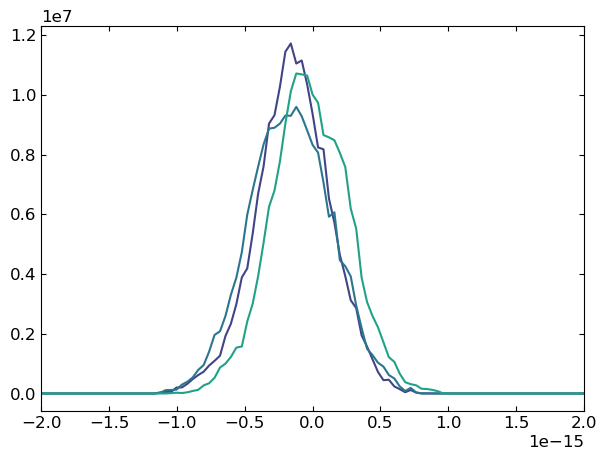

In [50]:
plt.plot(bc, hist_diff)
plt.plot(bc, hist_diff_nob_0)
plt.plot(bc, hist_diff_nob_1)

plt.xlim(-2e-15, 2e-15)

In [47]:
be = np.linspace(-1e-15, 1e-15, 250)
bc = 0.5 * (be[1:] + be[:-1])

hh_diff, _ = np.histogram(bb_diff, bins=be)
hh_diff_0n, _ = np.histogram(bb_diff_0n, bins=be)
hh_diff_1n, _ = np.histogram(bb_diff_1n, bins=be)

In [48]:
bb_diff

array([-9.57261696e-16,  1.97019074e-15, -4.87450265e-15, -4.43993157e-15,
       -1.19902025e-16, -4.87309286e-15,  1.33135778e-15, -6.88907744e-15,
        1.56177228e-15,  3.82675244e-16, -2.92808995e-15, -1.31015792e-15,
        2.80457174e-15, -3.68283910e-15,  7.05735862e-17, -4.64134760e-15,
        8.54498243e-15, -3.76432073e-15,  2.57107384e-15, -3.27274228e-15,
       -6.53253885e-15,  6.63458270e-16, -1.00566768e-15, -3.05934794e-15,
       -4.46997594e-16])

In [20]:
np.sum(hh_diff)

25

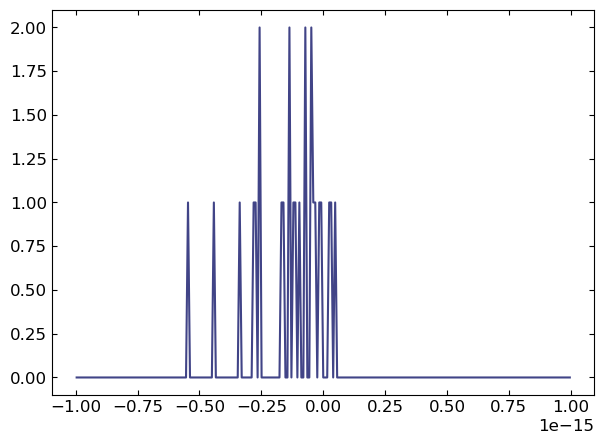

In [43]:
plt.plot(bc, hh_diff)